In [2]:
import sys
import os
sys.path.append('/Users/adam2392/Documents/tvb/')
# sys.path.append('/Users/adam2392/Documents/tvb/_tvbdata/')
# sys.path.append('/Users/adam2392/Documents/tvb/_tvblibrary/')
# from tvb.simulator.lab import *
import numpy as np
import pandas as pd
import scipy
from sklearn import cluster
import tvbsim

import processing.util as util
import processing.preprocessfft as preprocess

from natsort import natsorted

import tvbsim.util

%load_ext autoreload
%autoreload 2

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def _gettimepoints(numsignals, numwinsamps, numstepsamps):
    # create array of indices of window start times
    timestarts = np.arange(0, numsignals-numwinsamps+1, numstepsamps)
    # create array of indices of window end times
    timeends = np.arange(numwinsamps-1, numsignals, numstepsamps)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts.reshape(len(timestarts), 1), timeends.reshape(len(timestarts), 1), axis=1)
    return timepoints

# 1. Define Where Data Is

We need to get the data that is stored as FFT data.

We need to transform the data from 
- rawdataset is [numchans, numtimepoints]
- freqdata is the rawdata preprocessed into frequency data
[numchannels, numfrequencybands, numtimewindows]
- imagedata is freqdata reformatted into images
[width, height, numfreqbands, numtimewindows]

In [3]:
datadir = '/Volumes/ADAM LI/pydata/output/frequencyanalysis/'
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    

# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        if file.endswith(".npz"):
             datafiles.append(os.path.join(root, file))
print(datafiles)

['/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id001_ac_sim_nez1_npz1_dist4_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id001_ac_sim_nez1_npz1_dist3_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id001_ac_sim_nez1_npz1_dist2_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id001_ac_sim_nez1_npz1_dist5_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id002_cj_sim_nez1_npz1_dist7_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id014_rb_sim_nez1_npz1_dist1_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id014_rb_sim_nez1_npz1_dist6_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id002_cj_sim_nez1_npz1_dist6_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/frequencyanalysis/varydistance/id002_cj_sim_nez1_npz1_dist1_fftmodel.npz', '/Volumes/ADAM LI/pydata/output/freq

In [4]:
'''
This code segment should only be ran once, to extract metadata for each patient, 
so it doesn't need to be done in the loop for FFT compression.

EXTRACTS LOCATION DATA FOR EACH PATIENT
'''

patients = []
# get all patients in the dataset
for datafile in datafiles:
    filename = path_leaf(datafile)
    patient = '_'.join(filename.split('_')[0:2])
    if patient not in patients:
        patients.append(patient)
print(patients)

patient_dict = {}

# get all metadata for each patient
for patient in patients:
    project_dir = os.path.join(metadatadir, patient)
    confile = os.path.join(project_dir, "connectivity.zip")

    # get the regions, and region_centers from connectivity
    reader = util.ZipReader(confile)
    region_centers = reader.read_array_from_file("centres", use_cols=(1, 2, 3))
    regions = reader.read_array_from_file("centres", dtype=np.str, use_cols=(0,))
    
    # load in the vertices, normals and areas of gain matrix
    use_subcort = True
    verts, _, areas, regmap = tvbsim.util.read_surf(project_dir, use_subcort)
    
    patient_dict['project_dir'] = project_dir
    patient_dict['regions'] = regions
    patient_dict['region_centers'] = region_centers
    patient_dict['surf_data'] = (verts, areas, regmap)

['id001_ac', 'id002_cj', 'id014_rb']


# 2. Go Through Each Data File and Create Final Image Dataset

- imagedata is freqdata reformatted into images
[width, height, numfreqbands, numtimewindows]

Use functions to
- project 3D -> 2D coordinates
- mesh that 2D image with an imagesize and perform cubic interpolation
- create image

*Need labels [numsamples] that is {0,1} for when onset/offset is*

In [5]:
sys.path.append('/Users/adam2392/Documents/dnn-unsupervised/dnn/')
import processing.util as util

from sklearn.decomposition import PCA
import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
# define the data handler 
datahandler = util.DataHandler()
pca = PCA(n_components=2)

AZIM=0

# loop through each data file and get grid
for idx,datafile in enumerate(datafiles):
    # load data
    data = np.load(datafile, encoding='bytes')
    metadata = data['metadata'].item()
    
    power = data['power']
    print(power.shape)
    print(data.keys())
#     print(metadata.keys())
    
    # load xyz data for this particular dataset
    xyz_data = metadata[b'seeg_xyz']
    
    # project xyz data
    if AZIM==1:
        print("using azim projection to grid image")
        new_locs = []
        for ichan in range(0,xyz_data.shape[0]):
            new_locs.append(datahandler.azim_proj(xyz_data[ichan,:]))
        new_locs = np.asarray(new_locs)
    if AZIM==0:
        print("using pca to grid image")
        new_locs = pca.fit_transform(xyz_data)
     
    # Tensor of size [samples, freqbands, W, H] containing generated images.
    image_tensor = datahandler.gen_images(new_locs, power, 
                                n_gridpoints=32, normalize=True, augment=True, 
                                pca=False, std_mult=0.1, edgeless=False)
    # create grid for the image
    # Interpolate the values into a grid of x/y coords
#     grid_x, grid_y = np.mgrid[
#                              min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
#                              min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
#                          ]
    
#     # loop through each color
#     for c in range(n_colors):
#         # build feature array
#         feat_array_temp.append(features[:, c * numcontacts : numcontacts * (c+1)])
#         if augment: # add data augmentation -> either pca or not
#             feat_array_temp[c] = self.augment_EEG(feat_array_temp[c], std_mult, pca=pca, n_components=n_components)

#         # build temporary interpolator matrix    
#         temp_interp.append(np.zeros([numsamples, n_gridpoints, n_gridpoints]))
#     # Generate edgeless images -> add 4 locations (minx,miny),...,(maxx,maxy)
#     if edgeless:
#         min_x, min_y = np.min(locs, axis=0)
#         max_x, max_y = np.max(locs, axis=0)
#         locs = np.append(locs, np.array([[min_x, min_y], 
#                                          [min_x, max_y],
#                                          [max_x, min_y],
#                                          [max_x, max_y]]), axis=0)
#         for c in range(n_colors):
#             feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((numsamples, 4)), axis=1)
       


    print(new_locs.shape)
    break

(70, 126, 1759)
['phase', 'timepoints', 'freqs', 'power', 'metadata']
using pca to grid image
(1759, 70)


/Users/adam2392/Documents/dnn-unsupervised/dnn/processing/util.py:259: ComplexWarning: Casting complex values to real discards the imaginary part
  augData[:, f] = feat + np.random.normal(scale=stdMult*np.std(feat), size=feat.size)


Interpolating 1759/1759nterpolating 117/1759Interpolating 163/1759Interpolating 211/1759Interpolating 259/1759Interpolating 308/1759Interpolating 353/1759Interpolating 402/1759Interpolating 451/1759Interpolating 499/1759Interpolating 546/1759Interpolating 595/1759Interpolating 644/1759Interpolating 692/1759Interpolating 740/1759Interpolating 789/1759Interpolating 837/1759Interpolating 885/1759Interpolating 932/1759Interpolating 980/1759Interpolating 1026/1759Interpolating 1073/1759Interpolating 1121/1759Interpolating 1169/1759Interpolating 1217/1759Interpolating 1264/1759Interpolating 1311/1759Interpolating 1359/1759Interpolating 1407/1759Interpolating 1455/1759Interpolating 1503/1759Interpolating 1550/1759Interpolating 1596/1759Interpolating 1644/1759Interpolating 1692/1759Interpolating 1740/1759(70, 2)


NameError: name 'pca_locs' is not defined

(1759, 4, 32, 32)


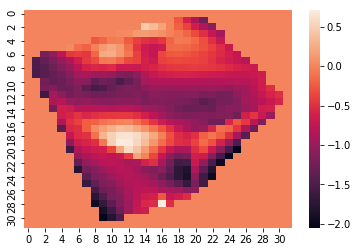

In [7]:
print(image_tensor.shape)
np.save('test_image.npy', image_tensor)
sns.heatmap(image_tensor[0,0,:,:].squeeze())

2.5


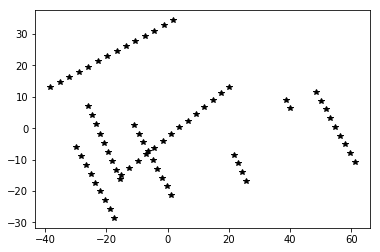

In [8]:
print(5/2)
pca_xyz = new_locs
fig = plt.figure()
plt.plot(pca_xyz[:,0], pca_xyz[:,1], 'k*')

fig = plt.figure()
# plt.plot(pca_locs[:,0], pca_locs[:,1], 'k*')

In [ ]:
# lists to store the list of tuples of seizure onset/offsets
seizuremarks = []

# list to store the last time point of each recording added in
timelens = []

for idx,datafile in enumerate(datafiles):
    powerbands, timepoints = preprocessor.compresspowermat(datafile)
    onsettimes, offsettimes = preprocessor.getseiztimes(datafile)
    
    metadata = preprocessor.loadmetadata(datafile)
    metadata['regions'] = regions
    metadata['region_centers'] = region_centers
    
    # get the last time point
    lasttimewin = timepoints[-1,:][1]+1
    timelens.append(lasttimewin)
    
    if idx > 0:
        onsettimes = list(np.asarray(onsettimes) + np.sum(timelens[0:idx-1]))
        offsettimes = list(np.asarray(offsettimes) + np.sum(timelens[0:idx-1]))
    seizuremarks_tuple = list(zip(onsettimes,offsettimes)) 
    seizuremarks.append(seizuremarks_tuple)
#     mapped_power_bands = preprocessor.projectpower_gain(powerbands,
#                                                         metadata,
#                                                        verts,
#                                                        areas,
#                                                        regmap)
#     print(mapped_power_bands.shape)
#     mapped_power_bands = preprocessor.projectpower_knn(powerbands,
#                                                         metadata)
#     print(mapped_power_bands.shape)
    mapped_power_bands = preprocessor.projectpower_invsquare(powerbands,
                                                        metadata)
#     print(onsettimes, offsettimes)
#     print(powerbands.keys())
#     print(powerbands[list(powerbands.keys())[0]].shape)
#     print(mapped_power_bands.shape)

    if idx == 0:
        condensed_power = mapped_power_bands
    else:
        condensed_power = np.concatenate((condensed_power, mapped_power_bands), axis=0)

print(condensed_power.shape)
print(seizuremarks)
print(timelens)